In [10]:
# We import all our dependencies.
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer

import sys
sys.path.append('../')

from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training

import os
import glob
import zipfile
import urllib
from tifffile import imread, imsave
from matplotlib import pyplot as plt
from tqdm import tqdm

from pathlib import Path

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


Found 21 files.
0.0
0.0
(21, 400, 400)
(21, 400, 400)


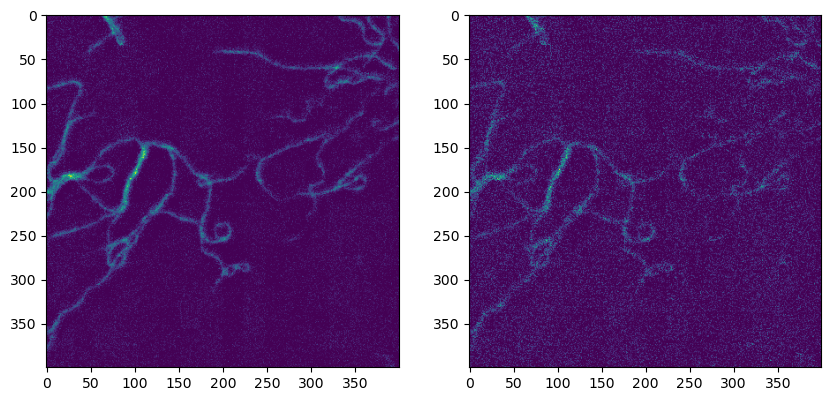

In [12]:
crop_size = 400
im_size = 1200
start = im_size//2-crop_size//2
stop = im_size//2+crop_size//2


# data paths
dataset_name = "Vimentin"
base_data_dir = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\inference\N2V")
data_path_signal = base_data_dir / "Vim_fixed_OnGtAvg_mse"
data_path_obs = base_data_dir / "Vim_fixed_OnInpSingle_mse"
signal = []
observation = []

filters = ['tif','tiff']

files_signal = os.listdir(data_path_signal)
files_obs = os.listdir(data_path_obs)

#print(files)
assert len(files_obs) == len(files_signal)
print(f"Found {len(files_signal)} files.")
for i in range (len(files_obs)):
    file_signal = files_signal [i]
    file_obs = files_obs [i]

    if file_signal.split('.')[-1] not in filters:
        print(f"skipping {file_signal} because not in filters")
        continue
    
    #load
    im_signal = imread(data_path_signal / file_signal)[0]
    im_obs  = imread(data_path_obs / file_obs)[0]

    #crop
    im_signal = im_signal[start:stop,start:stop]
    im_obs = im_obs[start:stop,start:stop]

    observation.append(im_obs)
    signal.append(im_signal)


signal = np.stack(signal)
observation = np.stack(observation)

#norm
signal = (signal -np.mean(signal)) / np.std(signal)
signal = signal + np.abs(np.min(signal))
observation = (observation -np.mean(observation)) / np.std(observation)
observation = observation + np.abs(np.min(observation))

print(np.min(observation))
print(np.min(signal))

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(signal[0])

plt.subplot(1,2,2)
plt.imshow(observation[0])
print(signal.shape)
print(observation.shape)

# Load our model

In [13]:
%%capture
model = torch.load("./Trained_model/model/Vimentin_Single_AvgHistogramCorrectNorm_NoAugment_best_vae.net")
model.mode_pred=True
model.eval()

# Compute PSNR
The higher the PSNR, the better the denoising performance is.
PSNR is computed using the formula: 

```PSNR = 20 * log(rangePSNR) - 10 * log(mse)``` <br> 
where ```mse = mean((gt - img)**2)```, ```gt``` is ground truth image and ```img``` is the prediction from HDN. All logarithms are with base 10.<br>
rangePSNR = max(```gt```)-min(```gt```) for as used in this [paper](https://ieeexplore.ieee.org/abstract/document/9098612/).

In [14]:
torch.cuda.empty_cache()


In [15]:

gaussian_noise_std = None
num_samples = 50 # number of samples used to compute MMSE estimate
tta = False # turn on test time augmentation when set to True. It may improve performance at the expense of 8x longer prediction time
psnrs = []
range_psnr = np.max(signal[0])-np.min(signal[0])

img_mmse_list = []
samples_list = []
# for i in range(observation.shape[0]):
for i in range (3):
    img_mmse, samples = boilerplate.predict(observation[i],num_samples,model,gaussian_noise_std,device,tta)
    img_mmse_list.append(img_mmse)
    samples_list.append(np.stack(samples))
    psnr = utils.PSNR(signal[0], img_mmse, range_psnr)
    psnrs.append(psnr)
    print("image:", i, "PSNR:", psnr, "Mean PSNR:", np.mean(psnrs))

100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


image: 0 PSNR: 25.048378705978394 Mean PSNR: 25.048378705978394


100%|██████████| 50/50 [00:03<00:00, 14.35it/s]


image: 1 PSNR: 4.583377838134766 Mean PSNR: 14.81587827205658


100%|██████████| 50/50 [00:03<00:00, 14.12it/s]

image: 2 PSNR: 9.74163681268692 Mean PSNR: 13.124464452266693


In [16]:
### saving solutions
saving_location = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\inference\HDN\aaa")
if not os.path.exists(saving_location):
    os.makedirs(saving_location)

for i in range(len(img_mmse_list)):
    summary = np.stack([signal[i],observation[i],img_mmse_list[i]])
    samples = samples_list[i]
    std = np.var(samples,axis=0)
    imsave(saving_location / f"inp_gt_mmse{num_samples}_{i:02d}.tif",summary,imagej=True,metadata={'axes':'TYX'})
    imsave(saving_location / f"samples_{i:02d}.tif",samples)
    imsave(saving_location / f"var_{i:02d}.tif",std)

In [17]:
samples.shape

(50, 400, 400)